![](../images/dino.jpg)
Photo credit [Nicola Stocchi](https://www.flickr.com/photos/124313328@N08/26611532154)

## Introduction
This implementation is based off of [this paper](https://arxiv.org/pdf/2104.14294.pdf) by FAIR. The reason I'm excited about this paper is because 
1. I was able to implement this by reading the paper (don't underestimate how convoluted this step is) 
2. We have a setting where we ignore any kind of labels altogether, i.e. completely self supervised.
3. We **don't need negative labels**.

In a nutshell what the paper attempts to do, is to take two different augmentations of the same image, and try and push these embeddings closer together. Most (and possibly all) other such tasks attempt to do a triplet loss where the image is compared to a similar image (positive example), and different image(s) (negative examples). What's amazing about this paper is that it ignores negative examples altogether and is still able to get a meaningful embedding space for a given image.

If you wish to run this live, please visit [this kaggle kernel](https://www.kaggle.com/sachin/dino-self-supervised-vision-transformers) instead of the colab link above.

In [1]:
#| include: false
!pip install deepspeed
!pip install --upgrade wandb
import copy
from functools import partial
import multiprocessing as mp
from pathlib import Path
from typing import Any, Callable, List, Tuple

from deepspeed.ops.adam import FusedAdam
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from sklearn.model_selection import train_test_split
import torch
from torch.distributions.bernoulli import Bernoulli
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import io, transforms
# from torchvision.utils import Image, ImageDraw
from torchvision.transforms.functional import to_pil_image
from tqdm.auto import tqdm

# Wandb login:
from kaggle_secrets import UserSecretsClient
import wandb
user_secrets = UserSecretsClient()
secret_value = user_secrets.get_secret("wandb_api_key")
wandb.login(key=secret_value)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

%matplotlib inline
print(torch.__version__, pl.__version__, wandb.__version__)

     |████████████████████████████████| 451 kB 1.1 MB/s 
     |████████████████████████████████| 216 kB 5.0 MB/s 
     |████████████████████████████████| 107 kB 5.2 MB/s 
     |████████████████████████████████| 14.9 MB 6.7 MB/s 
  Created wheel for deepspeed: filename=deepspeed-0.4.3-py3-none-any.whl size=454662 sha256=da5c6307dece440a6ab1ec47bf94d9bf05cbf16dac175d6ac7fd43061d87a5b9
  Stored in directory: /root/.cache/pip/wheels/4a/8d/93/598b6a20d6b1bd479345d9c7ae0d14d2ce897f966adadfec89
Successfully built deepspeed
  Attempting uninstall: tensorboardX
    Found existing installation: tensorboardX 2.2
    Uninstalling tensorboardX-2.2:
      Successfully uninstalled tensorboardX-2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
catalyst 21.4.1 requires tensorboardX>=2.1.0, but you have tensorboardx 1.8 which is incompatible.
     |████████████████████████████

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


1.7.0 1.2.8 0.11.0


In [2]:
#| code-fold: true
# Image parameters
TRAIN_FILES = "/kaggle/input/coco-2017-dataset/coco2017/train2017/"
IMAGE_SIZE = 256
PATCH_SIZE = 16
ZERO_PCT = 0.1
PATCHES_PER_ROW = (IMAGE_SIZE // PATCH_SIZE)
NUM_PATCHES = PATCHES_PER_ROW ** 2
RGB_CHANNELS = 3
NUM_PIXELS = PATCH_SIZE ** 2 * RGB_CHANNELS
VALID_IMAGES = 5
TOPK = 5

# Training parameters
BATCH_SIZE = 16
EPOCHS = 5
LR = 1e-4

# Transformer parameters
N_HEADS = 8
N_LAYERS = 6

# Update constants
TEMPERATURE_S = 0.1
TEMPERATURE_T = 0.05
CENTER_MOMENTUM = 0.9
TEACHER_MOMENTUM = 0.995

## Data

The following shows how a given image is passed through two transforms (`RandomResizedCrop`) with one guaranteed to be atleast half as large as the original image. A collate function is then used to break it up into 16x16 patches, and stack those patches into a sequence, so that we can fit it into a transformer. The collate function is a minor detail in the overall picture, but if you wish to read about it you can do so [here](https://sachinruk.github.io/blog/pytorch/data/2021/06/05/PyTorch-CollateFn.html).

In [3]:
class ImageData(Dataset):
    def __init__(self, files: List[str]):
        self.files = files
        self.randcrop_big = transforms.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE), scale=(0.5, 1.0))
        self.randcrop_small = transforms.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE))
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        img = io.read_image(self.files[i])
        img1 = self.randcrop_big(img)
        img2 = self.randcrop_small(img)
        if img.shape[0] == 1:
            img1 = torch.cat([img1]*3)
            img2 = torch.cat([img2]*3)

        return img1, img2

In [ ]:
#| code-fold: show
class CollateFn:
    def reshape(self, batch):
        patches = torch.stack(batch)\
                    .unfold(2, PATCH_SIZE, PATCH_SIZE)\
                    .unfold(3, PATCH_SIZE, PATCH_SIZE)

        num_images = len(patches)
        patches = patches.reshape(
            num_images,
            RGB_CHANNELS, 
            NUM_PATCHES, 
            PATCH_SIZE, 
            PATCH_SIZE
        )
        patches.transpose_(1, 2)
        
        return patches.reshape(num_images, NUM_PATCHES, -1) / 255.0 - 0.5
        
    def __call__(
        self, batch: List[Tuple[torch.Tensor, torch.Tensor]]
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        x1, x2 = zip(*batch)

        return self.reshape(x1), self.reshape(x2)

In [4]:
#| include: false
class ImageOriginalData(Dataset):
    def __init__(self, files: List[str]):
        self.files = files
        self.resize = transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        img = io.read_image(self.files[i])
        if img.shape[0] == 1:
            img = torch.cat([img]*3)

        return self.resize(img)
    
class CollateSingleImage(CollateFn):    
    def __call__(
        self, batch: List[torch.Tensor]
    ) -> torch.FloatTensor:
        return self.reshape(batch)
    
files = [str(file) for file in Path(TRAIN_FILES).glob("*.jpg")]
train_files, valid_files = train_test_split(files, test_size=0.15, random_state=42)

train_data = ImageData(train_files)
train_dl = DataLoader(
    train_data, 
    BATCH_SIZE, 
    shuffle=True, 
    drop_last=True, 
    num_workers=4,
    pin_memory=True,
    collate_fn=CollateFn(),
)

valid_data = ImageOriginalData(valid_files)
valid_dl = DataLoader(
    valid_data, 
    BATCH_SIZE*2, 
    shuffle=False, 
    drop_last=False, 
    num_workers=4,
    pin_memory=True,
    collate_fn=CollateSingleImage(),
)

In [5]:
#| include: false
x, y = next(iter(train_dl))
x2 = next(iter(valid_dl))
(x.shape, y.shape), (x2.shape)

((torch.Size([16, 256, 768]), torch.Size([16, 256, 768])),
 torch.Size([32, 256, 768]))

## Model
The model is simply the 256 image patches passed through an encoder transformer with a CLS token. However, a few things that I think newcomers to the transformer/ pytorch field ought to know is as follows (also I made these mistakes 😅).
- Make sure to use `self.register_parameter` when declaring trainable variables in pytorch. doing `self.myvar = nn.Parameter(...)` is not enough.
- I have used `LayerNorm` everywhere possible to keep gradient sizes reasonable for a optimizer with constant learning rate.

The walkthough of the model operation ignoring normalisations is as follows:
1. Take the flattened 3x16x16 image patches and append them to a positional encoding.
2. Pass this through a linear layer and append the CLS token embedding to this.
3. Pass this through transformer, and take the 0th token since this correspond to the CLS token.
4. Normalize this vector to unit length so that you have a final image embedding.

In [6]:
class Model(nn.Module):
    def __init__(self, d_model, n_head, n_layers):
        super().__init__()
        # transformer
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_head)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # positional embedding
        w_pos = torch.randn(NUM_PATCHES, d_model) / d_model ** 0.5
        cls_token = torch.randn(1, d_model) / d_model ** 0.5
        self.register_parameter("pos_embed", nn.Parameter(w_pos))
        self.register_parameter("cls_token", nn.Parameter(cls_token))

        # pixel projection
        self.linear = nn.Linear(2 * d_model, d_model)
        self.norm1 = nn.LayerNorm(2 * d_model, elementwise_affine=False)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        batch_size = len(x)
        position = torch.stack([self.pos_embed] * batch_size)
        x = torch.cat([x, position], dim=-1)
        pixel_proj = self.norm2(F.relu(self.linear(self.norm1(x))))
        batched_cls_token = torch.stack([self.cls_token]*batch_size)
        cls_x = torch.cat([batched_cls_token, pixel_proj], dim=1)
        
        cls_x.transpose_(0, 1)
        return F.normalize(self.encoder(cls_x)[0, ...], dim=-1)

## Cross Entropy Loss, sort of
We need a loss function that will push the output vector of the above model towards each other for the two augmented images. The way that this paper does it, is by treating the vector as a (log of) a histogram, and trying to line it up with its augmented version. Why is this interesting? Usually, most authors tend to simply take the dot product and maximise that to indicate that vectors need to line up (be close). This paper achieves the same result but by asking histograms to line up instead.

The cross entropy loss takes on the form of $-\sum_{j=1}^J y_j\log p(x_j)$. This is minimised when $p(x_j)$ tends towards $y_j$. Similarly if we were to replace $y_j$ with a probability distribution $q_j\in[0, 1]\text{ s.t. }\sum_j q_j = 1$, p_j is minimised when the distributions line up.

My personal intuition as to why this might be better might be as follows: (Feel free to correct me if I am wrong). When trying to maximise dot products, we are asking two points on a sphere to move towards each other. Now there is an obvious shortest path distance when you visualise it by drawing a line between the two points. However, going away from the point will also, eventually get you to the same point but by taking a longer time.

By using the following equation we need two histograms to line up, which is a simpler derivative, and therefore more likely to get to a local minima faster.
$$ \frac{1}{N}\sum_{n=1}^N\sum_{j=1}^J q_j\log p_j$$

Note that in the implementation below, we have extra two concepts of centering, and using a temperature. I'm not sure about the centering, but the temperature variable (which is positive but less than one), sharpens the histogram, making the peaks more prominent.

In [7]:
class HLoss:
    def __init__(self, temperature_t: float, temperature_s: float):
        self.temperature_t = temperature_t
        self.temperature_s = temperature_s
        
    def __call__(
        self, 
        t: torch.FloatTensor, 
        s: torch.FloatTensor, 
        center: torch.FloatTensor
    ) -> torch.FloatTensor:
        t = F.softmax((t.detach() - center) / self.temperature_t, dim=1)
        log_s = F.log_softmax(s / self.temperature_s, dim=1)

        return -(t * log_s).sum(dim=1).mean()

## Training
The `LightningModule` below goes through the training step. The main steps are:
1. Create two copies of the model with the exact same parameters. One would be considered teacher (with the gradients not being calculated at backprop) and the student.
2. Pass both augmentations through both student and teacher.
3. Calculate the loss function shown above for the two augmentations, but with one embedding from teacher and the other from the student.
4. Calculate the new exponentially weighted teacher parameters with the corresponding student parameters.
5. Calculate a new (exponentially weighted) center parameter from the embeddings passed through the teacher only.
Steps 1-4 being the most important aspects IMO. 5th step feels more like a trick needed to stabalize optimization.

The following gif from the [official repo](https://github.com/facebookresearch/dino) is an overview of the algorithm:
![](https://github.com/facebookresearch/dino/raw/main/.github/dino.gif)

In [8]:
#| include: false
resize = transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))

def get_closest(embedding: torch.FloatTensor, i: int):
    similarity = embedding @ embedding[i,:].T
    scores, idx = similarity.topk(TOPK)
    return scores.cpu().numpy(), idx.cpu().numpy()

def get_closest_wandb_images(embedding: torch.FloatTensor, i: int, files: List[str]):
    main_img = to_pil_image(resize(io.read_image(files[i])))
    closest_imgs = [wandb.Image(main_img)]
    
    scores, idx = get_closest(embedding, i)
    
    for i, score in zip(idx, scores):
        img = to_pil_image(resize(io.read_image(files[i])))
        closest_imgs.append(
            wandb.Image(img, caption=f"{score:.4f}")
        )
        
    return closest_imgs

The non-standard (and important to note) things I've done in the `LightningModule` are as follows:
- Set all parameters in `teacher` model to non-trainable.
- Register a buffer (not parameter) `center` to track the output of the teacher.
- At each `validation_epoch_end` randomly pick an image from validation set and find 5 closest images. Use these results and push it to weights and biases as a table of images.
- Every 50th batch save a histogram of gradients to weights and biases. This ensures that there is no gradient explosion or degredation as training evolves.

In [9]:
#| code-fold: show
class LightningModel(pl.LightningModule):
    def __init__(
        self,
        teacher: nn.Module,
        lr: float,
        loss_fn: Callable,
        valid_files: List[str],
        dim: int,
        center_momentum: float,
        param_momentum: float,
    ):
        super().__init__()
        self.teacher = teacher
        self.student = copy.deepcopy(teacher)
        self.lr = lr
        self.loss_fn = loss_fn
        self.c_mom = center_momentum
        self.p_mom = param_momentum
        self.register_buffer("center", torch.zeros((1, dim)).float())
        self.valid_files = valid_files
        
        for p in self.teacher.parameters():
            p.requires_grad = False

    def loss_calculation(
        self,
        batch: Tuple[torch.FloatTensor, torch.FloatTensor],
    ) -> torch.FloatTensor:
        x1, x2 = batch
        
        s1, s2 = self.student(x1), self.student(x2)
        t1, t2 = self.teacher(x1), self.teacher(x2)
        
        loss = self.loss_fn(t1, s2, self.center) + self.loss_fn(t2, s1, self.center)
        
        emperical_center = F.normalize(
            torch.cat([t1, t2]).mean(dim=0, keepdims=True),
            dim=-1,
        )
        return loss, emperical_center

    def training_step(
        self, batch: Tuple[torch.FloatTensor, torch.FloatTensor], *args: List[Any]
    ) -> torch.Tensor:
        loss, emperical_center = self.loss_calculation(batch)
        self.log(name="Training loss", value=loss, on_step=True, on_epoch=True)
        
        self.center = F.normalize(
            self.c_mom * self.center + (1 - self.c_mom) * emperical_center,
            dim=-1,
        )
        for s_p, t_p in zip(self.student.parameters(), self.teacher.parameters()):
            t_p.data = self.p_mom * t_p.data + (1 - self.p_mom) * s_p.data
            
        return loss
    
    def validation_step(self, images: torch.FloatTensor, *args: List[Any]) -> None:
        return self.teacher(images)
        
    def validation_epoch_end(self, validation_step_outputs):
        valid_embeds = torch.cat([pred for pred in validation_step_outputs])
        columns = ["image"] + [f"closest_{i+1}" for i in range(TOPK)]
        indices = np.random.choice(len(self.valid_files), VALID_IMAGES, replace=False)
        rows = [get_closest_wandb_images(valid_embeds, i, self.valid_files) for i in indices]
        table = wandb.Table(data=rows, columns=columns)
        self.logger.experiment.log({f"epoch {self.current_epoch} results": table})
        
    def on_after_backward(self):
        if self.trainer.global_step % 50 == 0:  # don't make the tf file huge
            global_step = self.trainer.global_step
            for name, param in self.student.named_parameters():
                if "weight" in name and not "norm" in name and param.requires_grad:
                    self.logger.experiment.log(
                        {f"{name}_grad": wandb.Histogram(param.grad.cpu())}
                    )

    def configure_optimizers(self) -> torch.optim.Optimizer:
        return FusedAdam(self.student.parameters(), lr=self.lr)

Thanks to PyTorch Lightning and WandB I can easily do half precision training and log the results to a beautiful dashboard, with results in the link below.

In [10]:
!mkdir /kaggle/working/logs
teacher = Model(NUM_PIXELS, N_HEADS, N_LAYERS)
h_loss = HLoss(TEMPERATURE_T, TEMPERATURE_S)
lightning_model = LightningModel(
    teacher, 
    LR,
    h_loss,
    valid_files,
    NUM_PIXELS,
    CENTER_MOMENTUM, 
    TEACHER_MOMENTUM,
)

logger = WandbLogger("DINO", "/kaggle/working/logs/", project="DINO")
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    gpus=torch.cuda.device_count(),
    gradient_clip_val=1.0,
    logger=logger,
    precision=16,
    num_sanity_val_steps=0,
)
trainer.fit(lightning_model, train_dl, valid_dl)

Using /root/.cache/torch_extensions as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/fused_adam...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/fused_adam/build.ninja...
Building extension module fused_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


wandb: Currently logged in as: sachinruk (use `wandb login --relogin` to force relogin)


Loading extension module fused_adam...
Time to load fused_adam op: 29.516473054885864 seconds


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

## Evaluate results
Finally lets look at some random images with its most closest images according to the model. Note that at this point, we throw away the student and simply take the teacher, even though it is only the student that used gradient information directly. The following image shows the weights and biases table that I created during training using **only** the validation dataset. The results that follow use the entire set of images and it's corresponding closest images. Considering that this is a self supervised task, this is not "cheating".
![](../images/wanb_table.jpg)

In [11]:
#| include: false
image_orig_data = ImageOriginalData(files)
image_orig_dl = DataLoader(
    image_orig_data, 
    BATCH_SIZE*2, 
    shuffle=False, 
    drop_last=False, 
    num_workers=4,
    pin_memory=True,
    collate_fn=CollateSingleImage(),
)

In [12]:
teacher = teacher.eval().to(device)
embedding = []
with torch.no_grad():
    for x in tqdm(image_orig_dl):
        out = teacher(x.to(device))
        embedding.append(out.cpu())
        
    embedding = torch.cat(embedding, dim=0)

  0%|          | 0/3697 [00:00<?, ?it/s]

In [13]:
#| include: false
def plot_closest_pairs(embedding, i, files):
    img = to_pil_image(resize(io.read_image(files[i])))
    plt.imshow(img)
    scores, idx = get_closest(embedding, i)
    
    fig, axs = plt.subplots(1, len(idx), figsize=(12, 5))
    for i, score, ax in zip(idx, scores, axs):
        img = to_pil_image(resize(io.read_image(files[i])))
        ax.imshow(img)
        ax.set_title(f"{score:.4f}")

    plt.show()

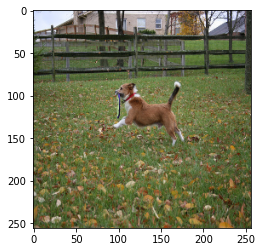

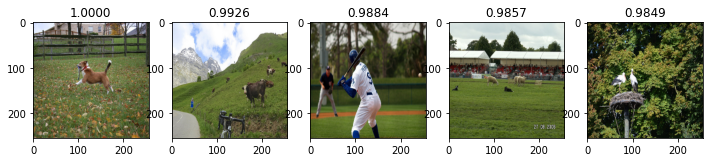

In [14]:
i = 64
plot_closest_pairs(embedding, i, files)

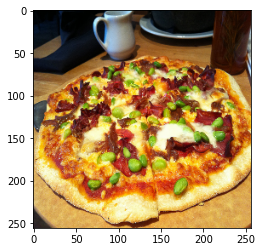

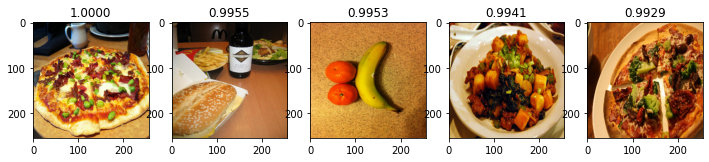

In [15]:
i = 42
plot_closest_pairs(embedding, i, files)

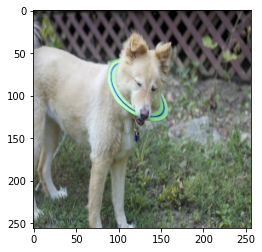

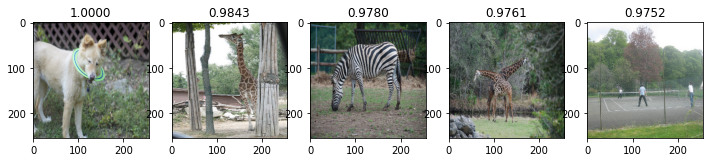

In [16]:
i = 21
plot_closest_pairs(embedding, i, files)

## Shameless Self Promotion
If you enjoyed the tutorial [buy my course](https://www.udemy.com/course/machine-learning-and-data-science-2021/?referralCode=E79228C7436D74315787) (usually 90% off).